## **U-Net with 1000 images**



*   Trying out the model as explained in Youtube tutorial: 
*   Used MinMax Scaler instead of dividing by 255
*   Images are stored in numpy array
*   Performance Metrics - Accuracy, Jacard Coeffcient as explained in video
*   Loss - Only binary crossentropy
*   1000 images - 100 epochs



**TO-DO**



1.   Use Image Data Generator - Keras (instead of numpy array)
2.   Add Dice coefficient, MCC as performance metrics
3.   Try for 1000 images - 10 epochs








In [1]:
!pip install keras-unet

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from keras_unet.utils import get_patches
from keras_unet.models import satellite_unet
import glob
import os
from keras import backend as K 
from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, BatchNormalization, Activation, add
from keras.models import Model, model_from_json
import torch
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, StandardScaler
print(torch.cuda.is_available())

%matplotlib inline

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------
True


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
train_image_paths_list = []
train_gt_paths_list = []
train_image_path = '/content/drive/MyDrive/airs-minisample/patch/train_images/train/'
train_label_path = '/content/drive/MyDrive/airs-minisample/patch/train_masks/train/'

for img_path in glob.glob(os.path.join(train_image_path, '*.tif')):
    train_image_paths_list.append(str(img_path))   
print("Total aerial satellite images : ",len(train_image_paths_list))

for img_path in glob.glob(os.path.join(train_label_path, '*.tif')):
    train_gt_paths_list.append(str(img_path))
print("Total segmented mask images : ",len(train_gt_paths_list))

train_image_paths_list.sort()
train_gt_paths_list.sort()

Total aerial satellite images :  1008
Total segmented mask images :  1008


In [5]:
train_X = []
for img in train_image_paths_list:
    img = cv2.imread(img, cv2.IMREAD_COLOR)
    resized_img = cv2.resize(img,(256, 256), interpolation = cv2.INTER_CUBIC)
    train_X.append(resized_img)

In [6]:
train_Y = []
for img in train_gt_paths_list:
    img = cv2.imread(img, cv2.IMREAD_GRAYSCALE)
    resized_img = cv2.resize(img,(256, 256), interpolation = cv2.INTER_CUBIC)
    train_Y.append(resized_img)
    
print(len(train_X), len(train_Y))

1008 1008


**With min_max scaler**

In [7]:
train_X = np.array(train_X)
train_Y = np.array(train_Y)

train_Y = train_Y.reshape((train_Y.shape[0],train_Y.shape[1],train_Y.shape[2],1))

In [8]:
scaler = MinMaxScaler()
train_X_scaler = scaler.fit_transform(train_X.reshape(-1, train_X.shape[-1])).reshape(train_X.shape)
train_Y_scaler = scaler.fit_transform(train_Y.reshape(-1, train_Y.shape[-1])).reshape(train_Y.shape)
print(train_X_scaler.shape, train_Y_scaler.shape)

(1008, 256, 256, 3) (1008, 256, 256, 1)


In [9]:
def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

def dice_coef(y_true, y_pred):
    smooth = 0.0
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def mcc(y_true, y_pred):
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0) * 1e2
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0) / 1e2

    up = tp*tn - fp*fn
    down = K.sqrt((tp+fp) * (tp+fn) * (tn+fp) * (tn+fn))

    mcc = up / (down + K.epsilon())
    # mcc = tf.where(tf.is_nan(mcc), tf.zeros_like(mcc), mcc)
    return mcc

In [10]:
UNetModel = satellite_unet(input_shape=(256, 256, 3))
# UNetModel.summary()

In [11]:
UNetModel.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = [jacard_coef, 'accuracy', dice_coef], run_eagerly = True)

In [12]:
# Check how to store as JSON
history = UNetModel.fit(x = train_X_scaler, y = train_Y_scaler, batch_size = 16, epochs = 10, verbose = 1)

Epoch 1/10
63/63 [==============================] - 74s 897ms/step - loss: 0.2732 - jacard_coef: 0.4001 - accuracy: 0.8860 - dice_coef: 0.5647
Epoch 2/10
63/63 [==============================] - 59s 933ms/step - loss: 0.2095 - jacard_coef: 0.5038 - accuracy: 0.9180 - dice_coef: 0.6682
Epoch 3/10
63/63 [==============================] - 59s 933ms/step - loss: 0.1968 - jacard_coef: 0.5226 - accuracy: 0.9237 - dice_coef: 0.6844
Epoch 4/10
63/63 [==============================] - 59s 939ms/step - loss: 0.1782 - jacard_coef: 0.5636 - accuracy: 0.9303 - dice_coef: 0.7189
Epoch 5/10
63/63 [==============================] - 59s 935ms/step - loss: 0.1671 - jacard_coef: 0.5801 - accuracy: 0.9357 - dice_coef: 0.7329
Epoch 6/10
63/63 [==============================] - 59s 937ms/step - loss: 0.1582 - jacard_coef: 0.5985 - accuracy: 0.9385 - dice_coef: 0.7456
Epoch 7/10
63/63 [==============================] - 59s 935ms/step - loss: 0.1625 - jacard_coef: 0.5886 - accuracy: 0.9354 - dice_coef: 0.7375

In [13]:
UNetModel.save_weights('/content/drive/MyDrive/airs-minisample/weights/unet-youtube-1000images-10epochs.h5')
UNetModel.save_weights('/content/drive/MyDrive/airs-minisample/weights/unet-youtube-1000images-10epochs.tf')

### **Graph**

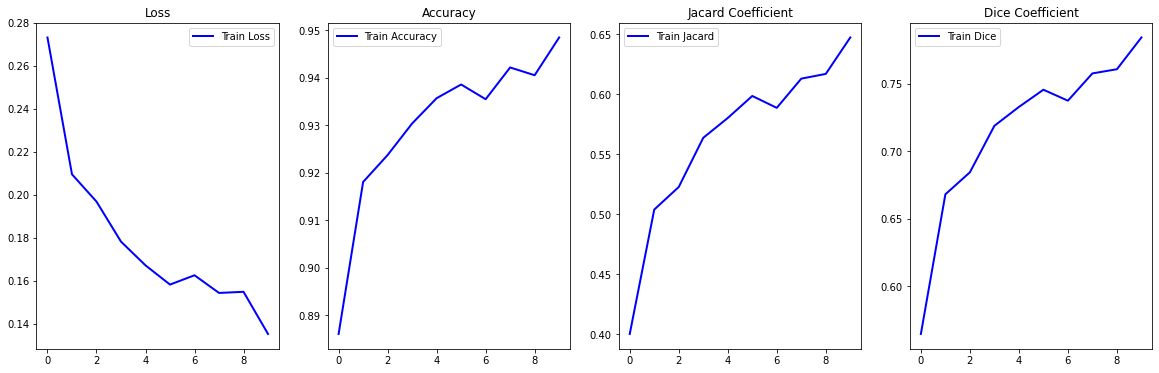

In [25]:
# Check how loss & mae went down
epoch_loss = history.history['loss']
# epoch_val_loss = history.history['val_loss']
epoch_acc = history.history['accuracy']
# epoch_val_acc = history.history['val_acc']
epoch_jac = history.history['jacard_coef']
# epoch_val_jac = history.history['jacard_coef']
epoch_dice = history.history['dice_coef']
# epoch_val_dice = history.history['dice_coef']

plt.figure(figsize=(20,6))
plt.subplot(1,4,1)
plt.plot(range(0,len(epoch_loss)), epoch_loss, 'b-', linewidth=2, label='Train Loss')
# plt.plot(range(0,len(epoch_val_loss)), epoch_val_loss, 'r-', linewidth=2, label='Val Loss')
plt.title('Loss')
plt.legend(loc='best')

plt.subplot(1,4,2)
plt.plot(range(0,len(epoch_acc)), epoch_acc, 'b-', linewidth=2, label='Train Accuracy')
# plt.plot(range(0,len(epoch_val_acc)), epoch_val_acc, 'r-', linewidth=2, label='Val Accuracy')
plt.title('Accuracy')
plt.legend(loc='best')

plt.subplot(1,4,3)
plt.plot(range(0,len(epoch_jac)), epoch_jac, 'b-', linewidth=2, label='Train Jacard')
# plt.plot(range(0,len(epoch_val_jac)), epoch_val_jac, 'r-', linewidth=2, label='Val Jacard')
plt.title('Jacard Coefficient')
plt.legend(loc='best')

plt.subplot(1,4,4)
plt.plot(range(0,len(epoch_dice)), epoch_dice, 'b-', linewidth=2, label='Train Dice')
# plt.plot(range(0,len(epoch_val_dice)), epoch_val_dice, 'r-', linewidth=2, label='Val Dice')
plt.title('Dice Coefficient')
plt.legend(loc='best')

plt.show()

### **Prediction on val image**

In [26]:
val_image_paths_list = []
val_gt_paths_list = []
val_image_path = '/content/drive/MyDrive/airs-minisample/patch/val_images/val/'
val_label_path = '/content/drive/MyDrive/airs-minisample/patch/val_masks/val/'

for img_path in glob.glob(os.path.join(val_image_path, '*.tif')):
    val_image_paths_list.append(str(img_path))        
print("Total tif images : ",len(val_image_paths_list))

for img_path in glob.glob(os.path.join(val_label_path, '*.tif')):
    val_gt_paths_list.append(str(img_path))        
print("Total tif images : ",len(val_gt_paths_list))

val_image_paths_list.sort()
val_gt_paths_list.sort()

Total tif images :  36
Total tif images :  36


In [27]:
val_X = []
val_Y = []
for img in val_image_paths_list:
    # print(img)
    img = cv2.imread(img, cv2.IMREAD_COLOR)
    resized_img = cv2.resize(img,(256, 256), interpolation = cv2.INTER_CUBIC)
    val_X.append(resized_img)
    
print('*****')
for img in val_gt_paths_list:
    # print(img)
    img = cv2.imread(img, cv2.IMREAD_GRAYSCALE)
    resized_img = cv2.resize(img,(256, 256), interpolation = cv2.INTER_CUBIC)
    val_Y.append(resized_img)
    
print(len(val_X), len(val_Y))

*****
36 36


In [28]:
val_X = np.array(val_X)
val_Y = np.array(val_Y)

val_Y = val_Y.reshape((val_Y.shape[0],val_Y.shape[1],val_Y.shape[2],1))

val_X = scaler.fit_transform(val_X.reshape(-1, val_X.shape[-1])).reshape(val_X.shape)
val_Y = scaler.fit_transform(val_Y.reshape(-1, val_Y.shape[-1])).reshape(val_Y.shape)
# val_X = val_X / 255.
# val_Y = val_Y / 255.

print(val_X.shape)
print(val_Y.shape)

(36, 256, 256, 3)
(36, 256, 256, 1)


Image number: 6


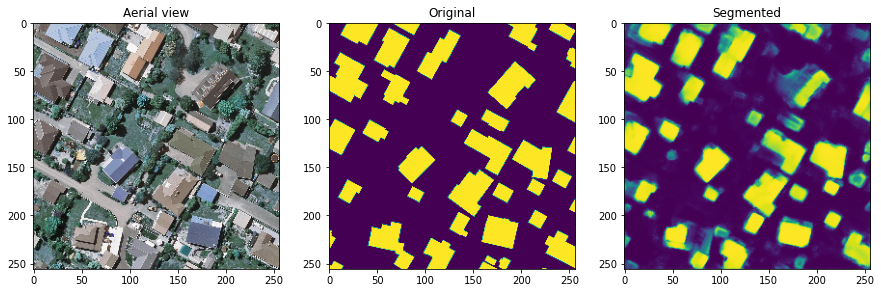

In [29]:
plt.figure(figsize=(15,15))
image_number = 6
print('Image number: {0}'.format(image_number))
pred_y = UNetModel.predict(val_X[image_number:image_number+1])
pred_y = pred_y / 255.
# pred_y = np.round(pred_y,0)

plt.subplot(1,3,1)
plt.imshow(np.squeeze(val_X[image_number:image_number+1]))
plt.title('Aerial view')

plt.subplot(1,3,2)
plt.imshow(np.squeeze(val_Y[image_number:image_number+1]))
plt.title('Original')

plt.subplot(1,3,3)
plt.imshow(np.squeeze(pred_y[0]))
plt.title('Segmented')

plt.show()

In [30]:
# tf.cast(inp, tf.float32)
print(jacard_coef(tf.cast(val_Y[16:17][0], tf.float32), tf.cast(pred_y[0], tf.float32)))

tf.Tensor(0.0010389038, shape=(), dtype=float32)
